In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
from __future__ import print_function
import os.path
import pandas
import src
import sklearn
import os
import scipy
import scipy.stats
from operator import itemgetter

In [3]:
def fake(*args, **kwargs):
    print('Fake called with', str(args), str(kwargs))
    sys.exit(1)

# fake out the create_model so we don't accidentally attempt to create data
src.common.create_model = fake

In [4]:
# import seaborn
# seaborn.set_palette("colorblind")

In [5]:
print(os.getcwd())
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(os.getcwd())

/home/cscorley/git/triage/notebooks
/home/cscorley/git/triage


In [6]:
def reload_projects(seed=1, name=None):
    args = dict(level='file', force=False, model='lda', source=['release', 'changeset', 'temporal'], random_seed_value=seed)

    model_config, model_config_string = src.main.get_default_model_config(args)
    args.update({'model_config': model_config, 'model_config_string': model_config_string})

    changeset_config, changeset_config_string = src.main.get_default_changeset_config()
    args.update({'changeset_config': changeset_config, 'changeset_config_string': changeset_config_string})

    projects = src.common.load_projects(args)
    if name:
        projects = [x for x in projects if x.name == name]
    return projects

In [7]:
projects = reload_projects(seed=1, name='bookkeeper')
projects

[Project(name='bookkeeper', printable_name='BookKeeper v4.3.0', version='v4.3.0', ref='refs/tags/release-4.3.0', data_path='data/bookkeeper/', full_path='data/bookkeeper/v4.3.0/', src_path='data/bookkeeper/v4.3.0/src/', changeset_config_string=u'True-True-False-True', source=['release', 'changeset', 'temporal'], model_config_string=u'seed1-batch-0.002-0.5-0.002-1000-1000-500-1.0-1', force=False, level='file', model_config={'passes': 1, 'eta': 0.002, 'num_topics': 500, 'iterations': 1000, 'decay': 0.5, 'algorithm': 'batch', 'alpha': 0.002, 'offset': 1.0, 'max_bound_iterations': 1000}, model='lda', random_seed_value=1, changeset_config={'include_removals': True, 'include_context': True, 'include_message': False, 'include_additions': True})]

# Data read

In [8]:
FIG_TEX="""
\\begin{figure}
\\centering
\\includegraphics[height=0.4\\textheight]{%s}
\\caption{%s: %s effectiveness measures for %s}
\\label{fig:%s}
\\end{figure}
"""

def plot_panel(panel, order, name, kind, seed):
    size = (len(order)*1.6, 4.5)
    fontsize = None
    widths = 0.3
    lower = 0
    kinds = {"flt_seed": "Feature Location",
             "dit_seed": "Developer Identification"}
    
    rqs = {"flt_seed": {"rq1": "RQ 3.3.1", "rq2": "RQ 3.3.2", "all": "Overview"},
           "dit_seed": {"rq1": "RQ 3.4.1", "rq2": "RQ 3.4.2", "all": "Overview"}}

    allt = pandas.DataFrame()
    for each in panel:
        allt = allt.append(panel[each], ignore_index=True)

        upper = panel[each][order].max().max()+1
        panel[each].plot(kind='box',
                         fontsize=fontsize,
                         figsize=size,
                         widths=widths,
                         ylim=(lower, upper),
                         y=order)
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        short_each = each.lower().split(' ')[0]
        fig_name = 'figures/%s/%s_%s_%s' % (kind, name, short_each, str(seed))
        path = os.path.expanduser('~/git/dissertation/') + fig_name
        plt.savefig(path + ".pdf", dpi=300)
        
        with open(path + ".tex", "wt") as f:
            figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
            f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], each + " with $seed=%s$" % str(seed), figlabel))
        plt.close()
        
        
    upper = allt.max().max()+1
    allt.plot(kind='box', figsize=(4,1.5), grid=False, vert=False, y=list(reversed(order)))
    plt.tight_layout()
    short_each = "tiny"
    fig_name = 'figures/%s/%s_%s_%s' % (kind, name, short_each, str(seed))
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)

    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], "all subject systems with $seed=%s$" % str(seed), figlabel))
        
    plt.close()
    
    allt.plot(kind='box',
               fontsize=fontsize,

              figsize=size,
              widths=widths,
              ylim=(lower, upper),
              y=order)
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    short_each = "overview"
    fig_name = 'figures/%s/%s_%s_%s' % (kind, name, short_each, str(seed))
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)
    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], "all subject systems with $seed=%s$" % str(seed), figlabel))
    plt.close()

In [9]:
RQ1_ORDER = ["Snapshot", "Changesets"]
RQ2_ORDER = ["Changesets", "Historical"]

In [10]:
def get_panel(projects, fn):
    datarank = dict()
    for project in projects:
        results = fn(project) 
        x, y = src.common.merge_first_rels(results['changeset'], results['release'], ignore=True)
        #_, z = src.common.merge_first_rels(results['changeset'], results['temporal'], ignore=True)
        #print(len(x), len(y))
        datarank[project.printable_name] = {'Changesets': pandas.Series(x),
                                            'Snapshot': pandas.Series(y)}
                                            #'Historical': pandas.Series(z)}

    return pandas.Panel(datarank)

In [119]:
fpanels = list()
tpanels = list()
print("seed: ", end='')
for seed in range(1, 51):
    print(seed, end=', ')
    projects = reload_projects(seed=seed, name='bookkeeper')

    fpanel = get_panel(projects, src.feature_location.run_experiment)
    tpanel = get_panel(projects, src.triage.run_experiment)
    
    fpanels.append(fpanel)
    tpanels.append(tpanel)

    plot_panel(tpanel, RQ1_ORDER, "rq1", "dit_seed", seed)
    plot_panel(fpanel, RQ1_ORDER, "rq1", "flt_seed", seed)

seed:1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 

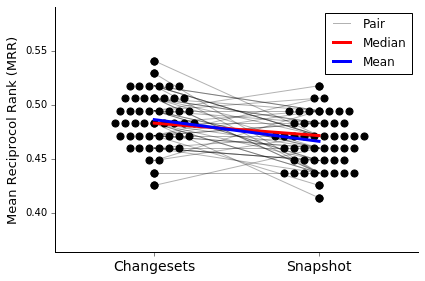

In [109]:
# http://stackoverflow.com/a/32680477/615429

import numpy as np
import matplotlib.pyplot as plt  
#--------------------------------
def points(x,y,n): # Plot n points symmetrically aligned about axes
    dx=0.03  # define distance between individual dots    
    m = 1-(n%2) # ensure symmetrical alignment for odd or even number of dots
    while(m<n):
        plt.scatter(x+(dx*m),y,color = 'k', marker = 'o', s=50, zorder=1)
        plt.scatter(x-(dx*m),y,color = 'k', marker = 'o', s=50, zorder=1)
        m+=2

def histogram(b): # count number of data points in each bin
    for col in range(0,2):
        count = np.unique(b[:,col], return_counts=True)  
        for n in range(0,np.size(count[col])):
            points(col,count[0][n], count[1][n])

def partition(a,bins): # partition continuous data into equal sized bins for plotting     
    lo = np.min(a)
    hi = np.max(a)
    rng = hi-lo
    step = rng/float(bins-1)

    for col in range (0,2):
        for row in range (0,int(np.size(a,axis=0))):
            for n in range (0,bins):
                 if a[row,col] <= (lo + (step / 2) + n * step):
                        b[row,col] = (lo + (n * step))
                        break
    return(b)

def lines(b): # draw 'before' and 'after' lines between paired data points + median line
    labeled=False
    for row in range (0,int(np.size(a,axis=0))):
        if labeled:
            plt.plot([0,1], [b[row,0], b[row,1]], c='k', zorder=0, lw=1, alpha=0.3)
        else:
            plt.plot([0,1], [b[row,0], b[row,1]], c='k', zorder=0, lw=1, alpha=0.3, label='Pair')
            labeled=True
    plt.plot([0,1], [np.median(b[:,0]),np.median(b[:,1])], c='r', zorder=2, lw=3, alpha=1, label='Median')
    plt.plot([0,1], [np.mean(b[:,0]),np.mean(b[:,1])], c='b', zorder=2, lw=3, alpha=1, label='Mean')
    plt.legend(loc='best')

def plot_pairs(pairs, name, kind, seed):
    #================================    
    # MAIN   
    # Dummy paired continuous data (...or import from spreadsheet as a numpy array)\;    
    a = np.array(pairs.T)

    start = pairs.min().min() - 0.05
    end = pairs.max().max() + 0.05
    step = 0.02

    bins = len(np.arange(start, end, step)) # pairs.count().max() # choose total number of bins to categorise data into
    ax = plt.axes()

    a = a.transpose()
    b = np.array(a) # make a copy of the input data matrix to write categorised data to
    b = partition(a, bins) # partition continuous data into bins
    lines(b) # draw lines between mid points of each bin and draw median line
    histogram(b) # draw histograms centered at mid points of each bin

    # Make general tweaks to plot appearance here:
    plt.xticks([0,1], ['Changesets', 'Snapshot'], fontsize=14)
    plt.ylabel('Mean Reciprocol Rank (MRR)',fontsize=13)
    # plt.text(0.8,1.3,'All patients',fontsize=13)
    ax.patch.set_facecolor('white') # set background colour for plot area (default = white)
    ax.spines['top'].set_visible(False)   # remove default upper axis
    ax.spines['right'].set_visible(False) # remove default right axis
    plt.tick_params(axis='both', 
                    which='both',
                    direction='out',
                    top='off',
                    right='off',
                    labeltop='off') # remove tick marks from top & right axes
    plt.xlim(-0.6,1.6)
    plt.ylim(pairs.min().min() - 0.05, pairs.max().max() + 0.05)
    fig = plt.gcf()
    fig.set_figheight(4)
    fig.set_figwidth(6)

    plt.tight_layout()
    plt.show()

    short_each = "paired_seeds"
    fig_name = 'figures/%s/%s_%s_%s' % (kind, name, short_each, str(seed))
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)
    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name, rqs[kind][name], kinds[kind], "all subject systems with $seed=%s$" % str(seed), figlabel))
    plt.close()

In [116]:
def get_pairs(panels):
    for idx, each in enumerate(panels):
        cs = list()
        sn = list()
        for name in each:
            cs.append(src.utils.calculate_mrr(each[name]['Changesets']))
            sn.append(src.utils.calculate_mrr(each[name]['Snapshot']))

        pairs = pandas.DataFrame({'Changesets': cs, 'Snapshot': sn}, index=range(1, 51))
        plot_pairs(pairs, name)

In [117]:
# need to unpack one project at a time out of the panels